# Correlation between single trials and outcome rating (3 tasks)
* Using single trial beta maps, I correlate the outcome ratings, i.e. behavioral ratings from each participant
* The correlation coefficients are converted to fisher z scores and saved as subject-wise correlation maps
* In this notebook, I concatenate the subject-wise correlation maps and conduct a t-test
* Afterwards, I convert back the fisher-z to correlation values and plot the thresholded maps

In [31]:
import numpy as np
import glob
import os
import pathlib
import re
import statsmodels 
from statsmodels.stats import multitest
import scipy
import nilearn
from scipy import stats
from nilearn.image import resample_to_img, math_img
from nilearn import image
from nilearn import plotting
import argparse
from nilearn.image import new_img_like
import matplotlib.pyplot as plt
from os.path import join


# pain

### load and stack images
conduct t-test
convert values back to corr values



In [32]:
main_dir = '/Volumes/spacetop_projects_cue/'
task = 'pain'
fmri_event = 'stimulus'
beh_regressor = 'outcomerating'
nii_flist = glob.glob(join(main_dir, 'analysis', 'fmri', 'nilearn', 'covariate', beh_regressor, task,  f"sub-*_task-{task}_corr_x-{fmri_event}_y-{beh_regressor}.nii.gz" ))

In [33]:
remove_sub = [1]
filtered_file_list = [file_path for file_path in nii_flist if not any(str(num) in file_path for num in remove_sub)]

In [34]:
len(filtered_file_list)

65

In [35]:
filtered_file_list[0:5]

['/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/covariate/outcomerating/pain/sub-0084_task-pain_corr_x-stimulus_y-outcomerating.nii.gz',
 '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/covariate/outcomerating/pain/sub-0077_task-pain_corr_x-stimulus_y-outcomerating.nii.gz',
 '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/covariate/outcomerating/pain/sub-0074_task-pain_corr_x-stimulus_y-outcomerating.nii.gz',
 '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/covariate/outcomerating/pain/sub-0083_task-pain_corr_x-stimulus_y-outcomerating.nii.gz',
 '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/covariate/outcomerating/pain/sub-0033_task-pain_corr_x-stimulus_y-outcomerating.nii.gz']

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/_utils/niimg.py:62: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/plotting/find_cuts.py:69: UserWarning: Given img is empty. Returning default cut_coords=(0.0, 0.0, 0.0) instead.
  warnings.warn(
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


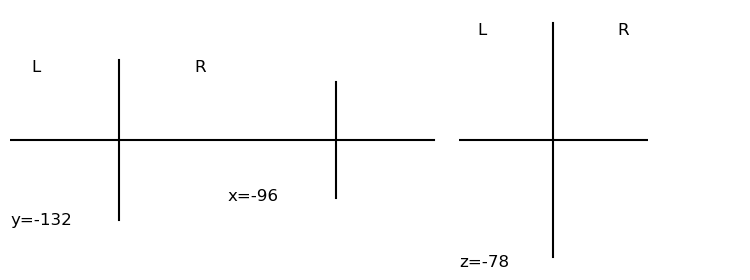

In [36]:
plotting.plot_stat_map(filtered_file_list[0])

In [37]:
# stack all files into a 4d nifti
concatenated_image = image.concat_imgs(sorted(filtered_file_list))


In [38]:
concatenated_image.get_fdata().shape

(73, 86, 73, 65)

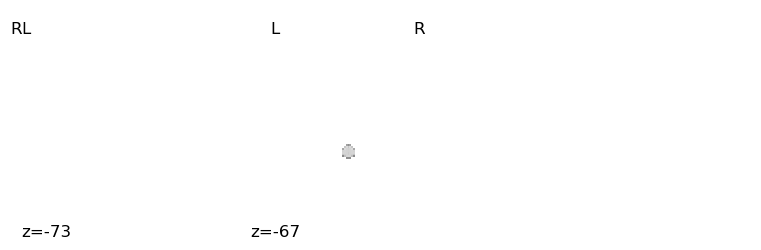

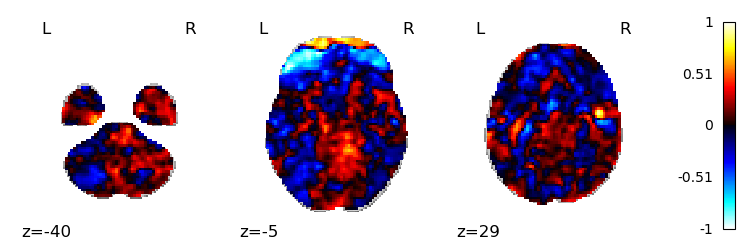

In [39]:
mean1 = image.mean_img(filtered_file_list[0])
mean2 = image.mean_img(filtered_file_list[1])
plotting.plot_stat_map(mean1, display_mode='z', cut_coords=3)
plotting.plot_stat_map(mean2, display_mode='z', cut_coords=3)

mean image

### mask images

In [40]:
# imgfname = join(main_dir, f'analysis/fmri/nilearn/singletrial/sub-0060/sub-0060_ses-01_run-05_runtype-vicarious_event-{fmri_event}_trial-011_cuetype-low_stimintensity-low.nii.gz')
# ref_img = image.load_img(imgfname)

mask = image.load_img('/Users/h/Documents/MATLAB/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii')
first_image = image.index_img(concatenated_image, 0)
mask_img = nilearn.masking.compute_epi_mask(mask, target_affine = first_image.affine, target_shape = first_image.shape)

nifti_masker = nilearn.maskers.NiftiMasker(mask_img= mask_img,
                                           smoothing_fwhm=6,
                            target_affine = first_image.affine, target_shape = first_image.shape, 
                    memory="nilearn_cache", memory_level=1)

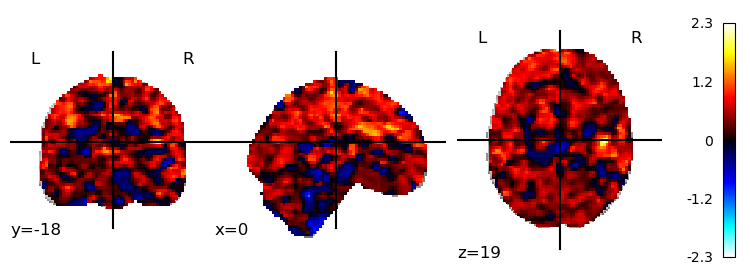

In [41]:
plotting.plot_stat_map(first_image)


In [42]:
fmri_masked = nifti_masker.fit_transform(concatenated_image)

In [43]:
fmri_masked.shape

(65, 98053)

# ttest

In [44]:
tvalues, pvalues = scipy.stats.ttest_1samp(fmri_masked, popmean=0,axis=0, alternative='two-sided', nan_policy = 'propagate')
reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')

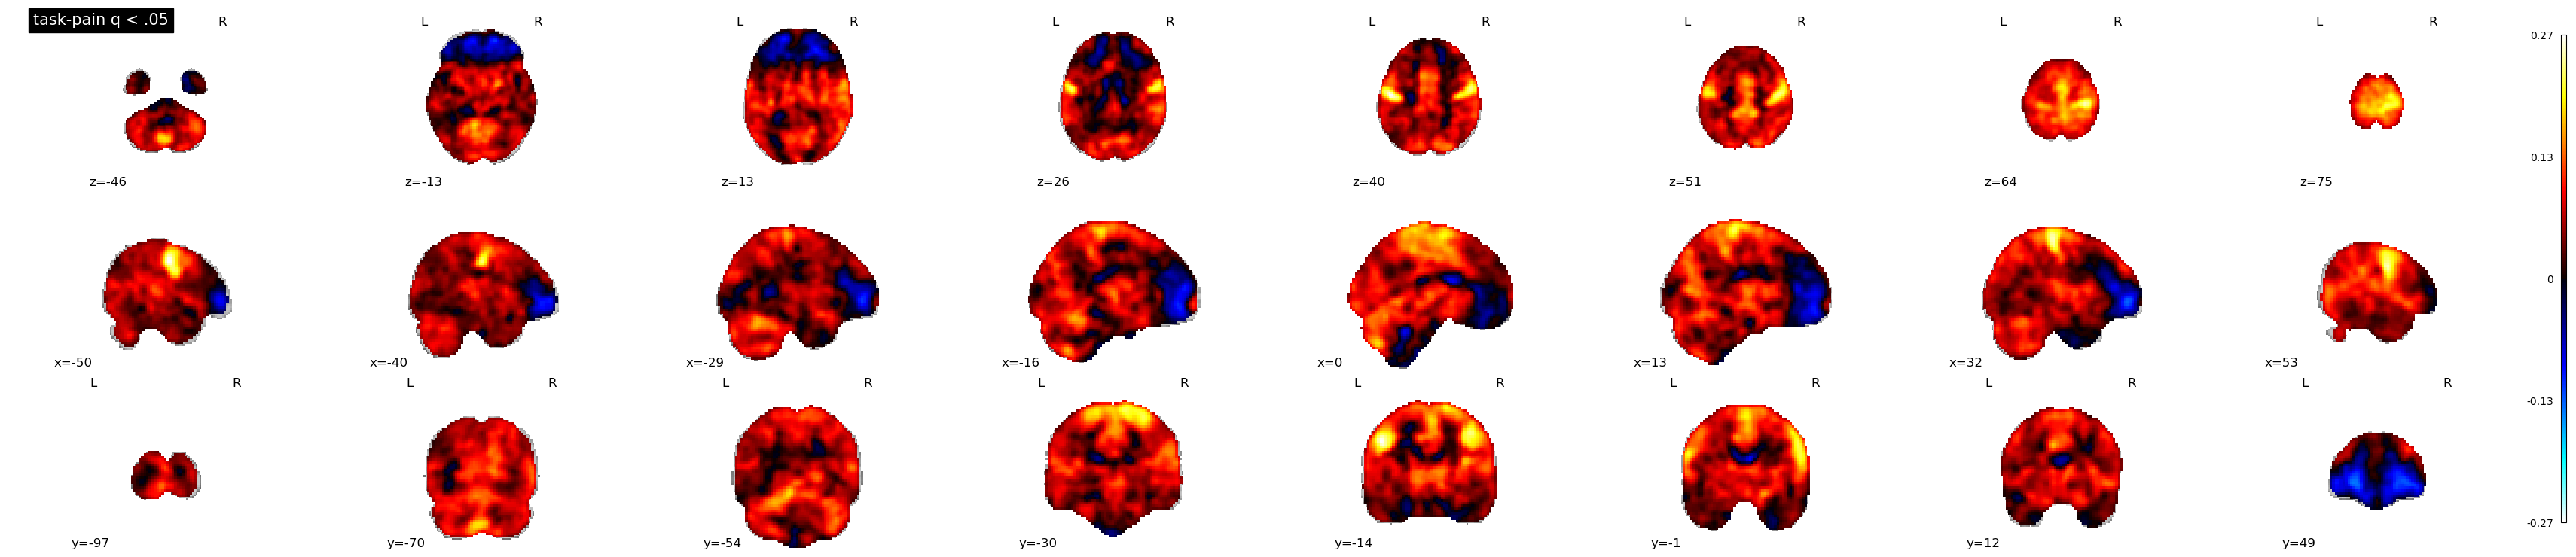

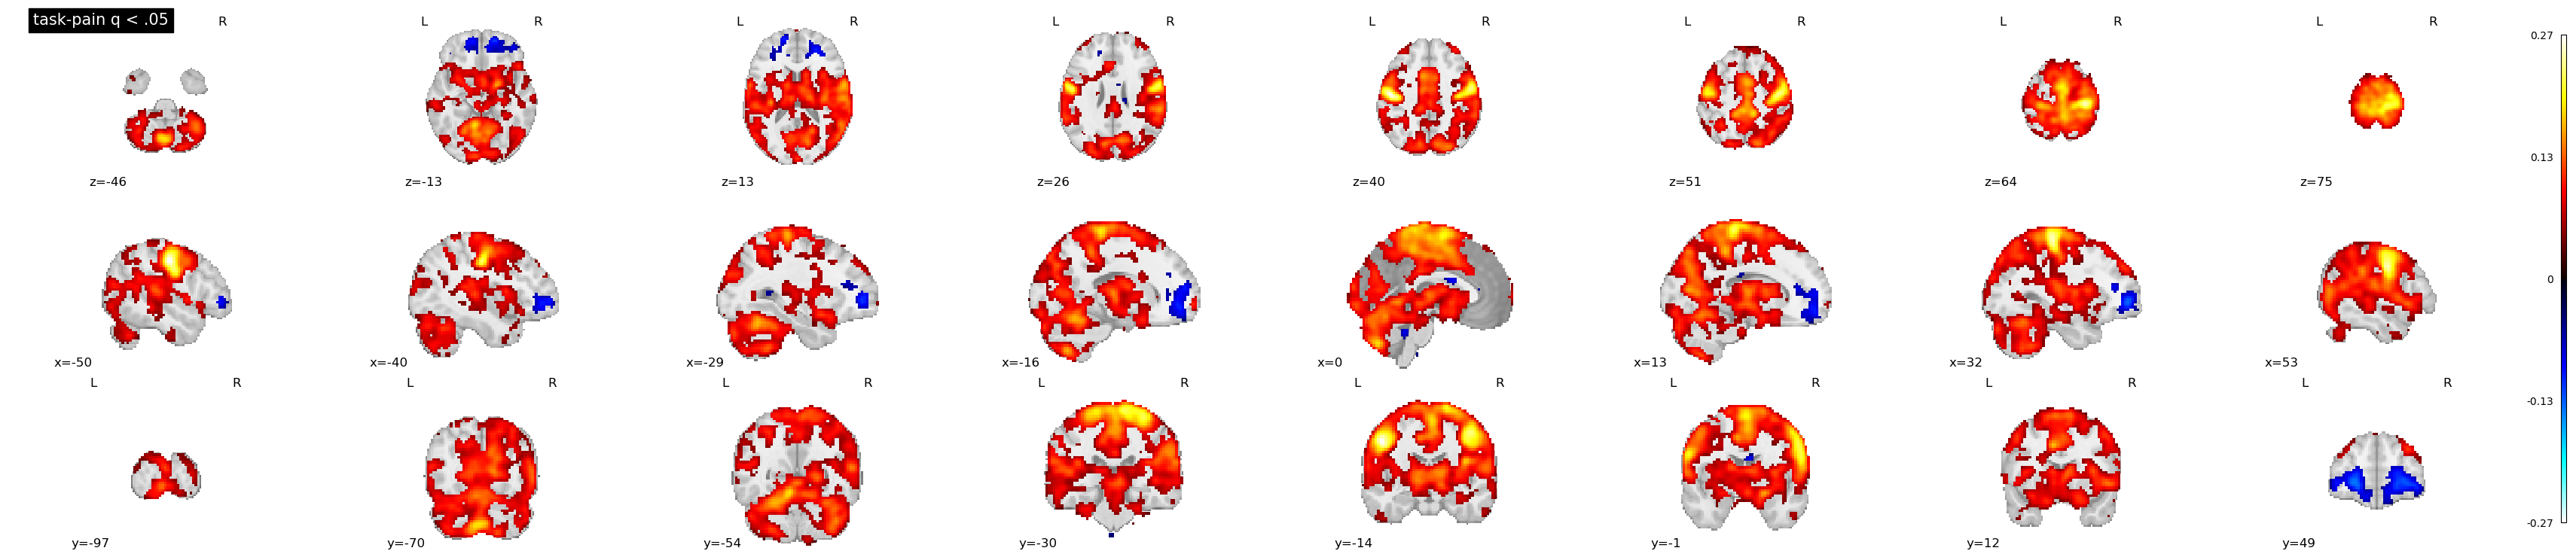

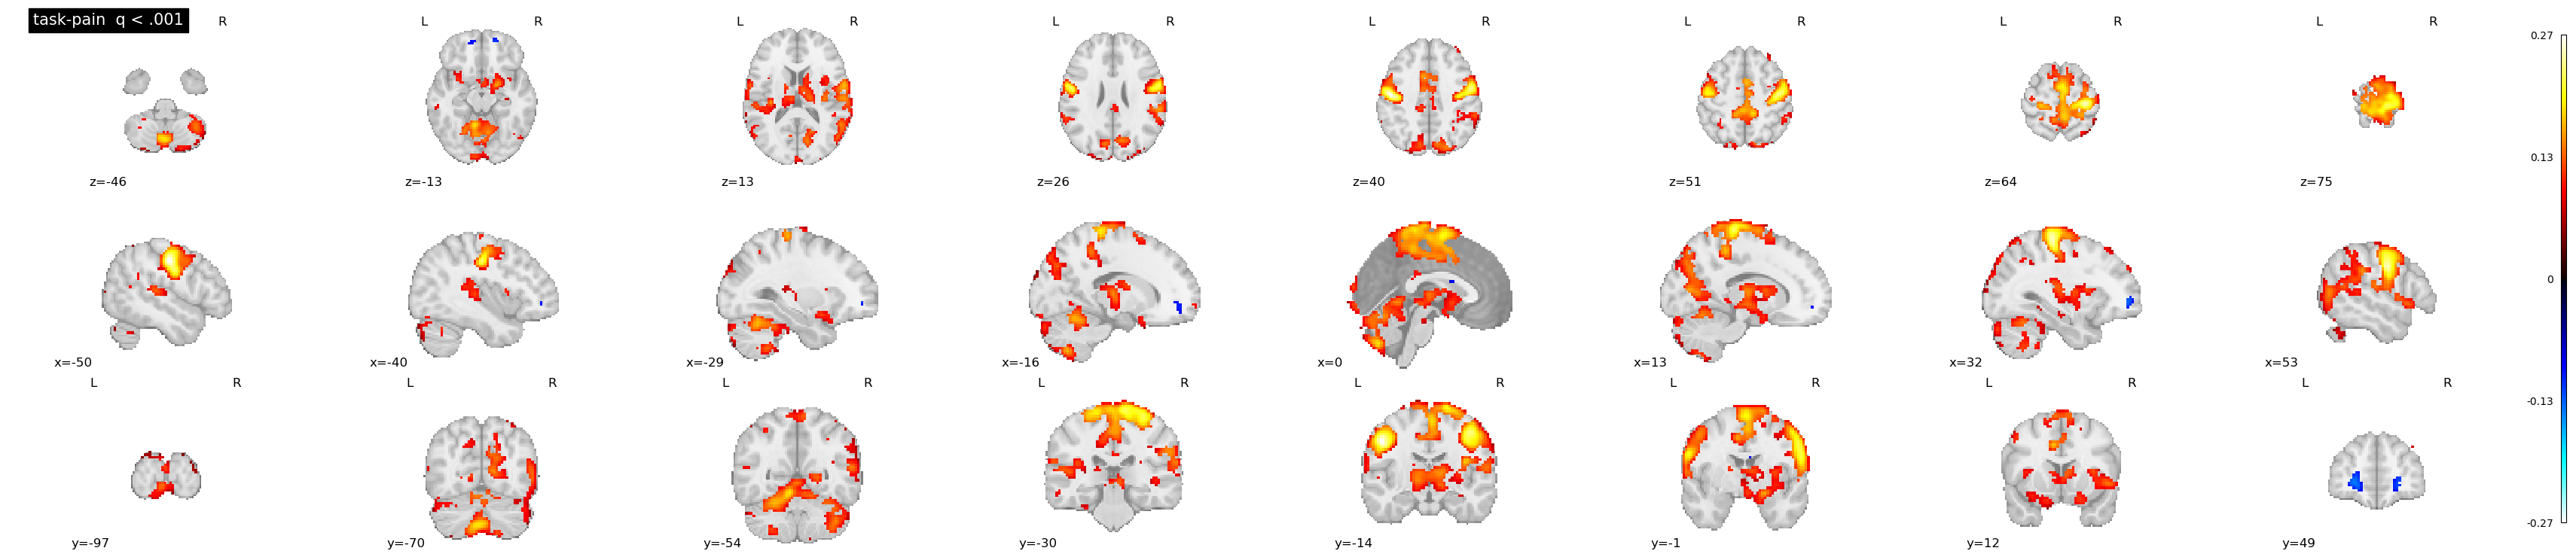

In [45]:
# tvalues, pvalues = scipy.stats.ttest_rel(fmri_masked_stimhighp, fmri_masked_stimlowp, axis = 0, nan_policy = 'propagate',alternative='two-sided' )
# reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')
tanhcorr_t = np.tanh(np.nanmean(fmri_masked, axis = 0))
                     
# map 1
con_t = nifti_masker.inverse_transform(tanhcorr_t)

# map 2
result_mapp = np.zeros(fmri_masked.shape[1])
result_mapp[qvalues < .05] = tanhcorr_t[qvalues < .05] #tvalues[qvalues < .05]
con_tmapp = nifti_masker.inverse_transform(result_mapp)

# map 3
result_map_001p = np.zeros(fmri_masked.shape[1])
result_map_001p[qvalues < .001] = tanhcorr_t[qvalues < .001] #tvalues[qvalues < .001]
con_tmap_001p = nifti_masker.inverse_transform(result_map_001p)

plotting.plot_stat_map(con_t,  display_mode = 'mosaic', title = 'task-pain q < .05', cut_coords = 8)
plotting.plot_stat_map(con_tmapp,  display_mode = 'mosaic', title = 'task-pain q < .05', cut_coords = 8)
plotting.plot_stat_map(con_tmap_001p,  display_mode = 'mosaic', title = 'task-pain  q < .001', cut_coords = 8)

# vicarious

In [46]:
nii_flist

['/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/covariate/outcomerating/pain/sub-0084_task-pain_corr_x-stimulus_y-outcomerating.nii.gz',
 '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/covariate/outcomerating/pain/sub-0101_task-pain_corr_x-stimulus_y-outcomerating.nii.gz',
 '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/covariate/outcomerating/pain/sub-0112_task-pain_corr_x-stimulus_y-outcomerating.nii.gz',
 '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/covariate/outcomerating/pain/sub-0018_task-pain_corr_x-stimulus_y-outcomerating.nii.gz',
 '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/covariate/outcomerating/pain/sub-0120_task-pain_corr_x-stimulus_y-outcomerating.nii.gz',
 '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/covariate/outcomerating/pain/sub-0077_task-pain_corr_x-stimulus_y-outcomerating.nii.gz',
 '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/covariate/outcomerating/pain/sub-0126_task-pain_corr_x-stimulus_y-outcomerating.n

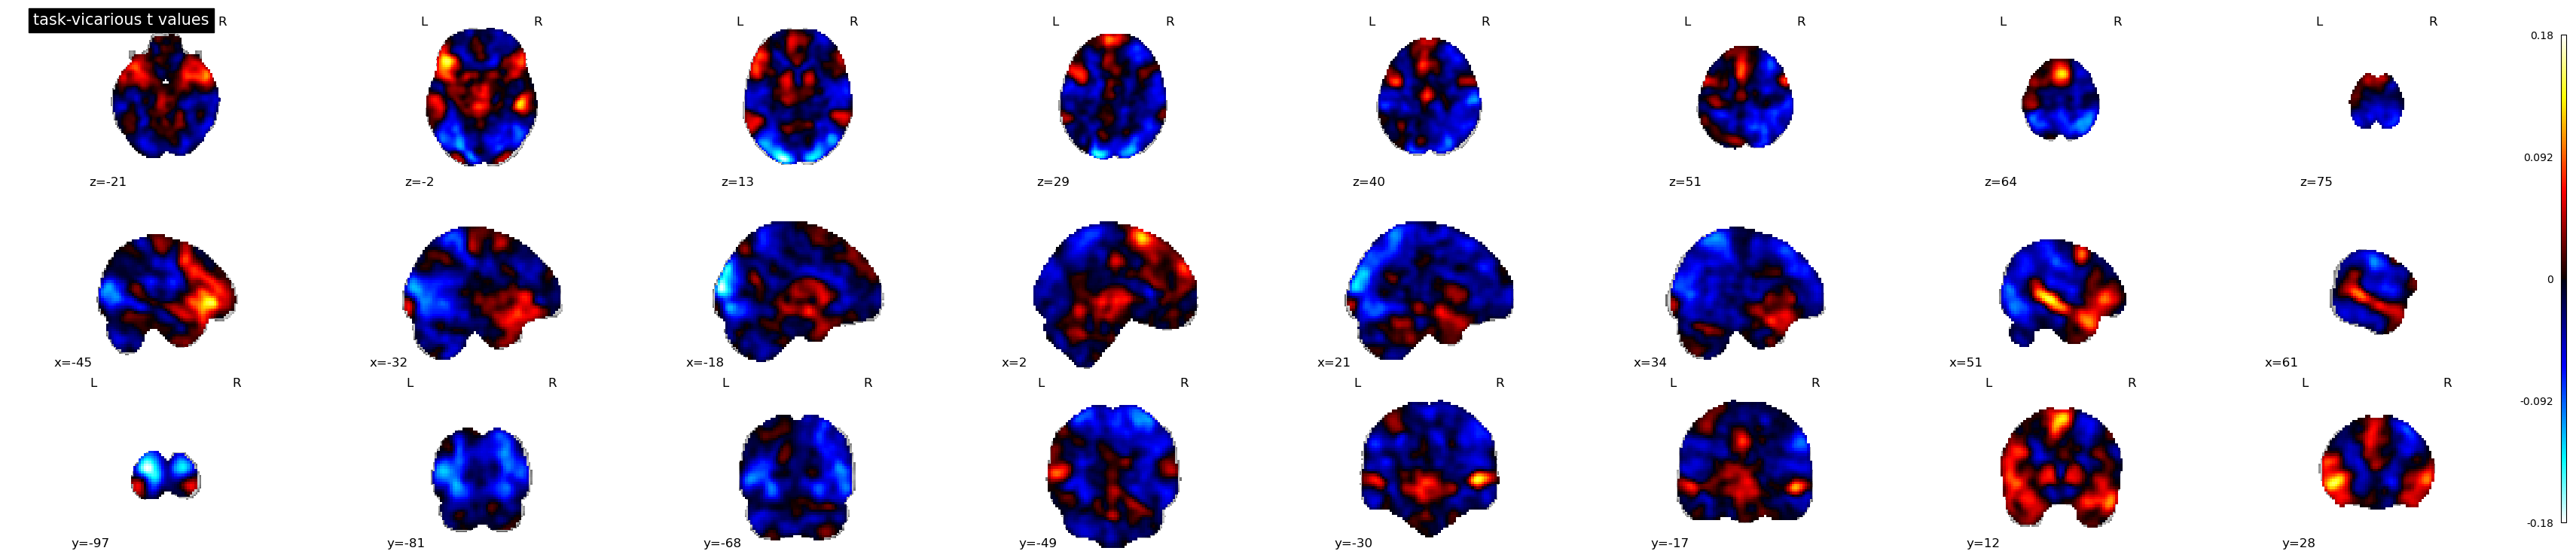

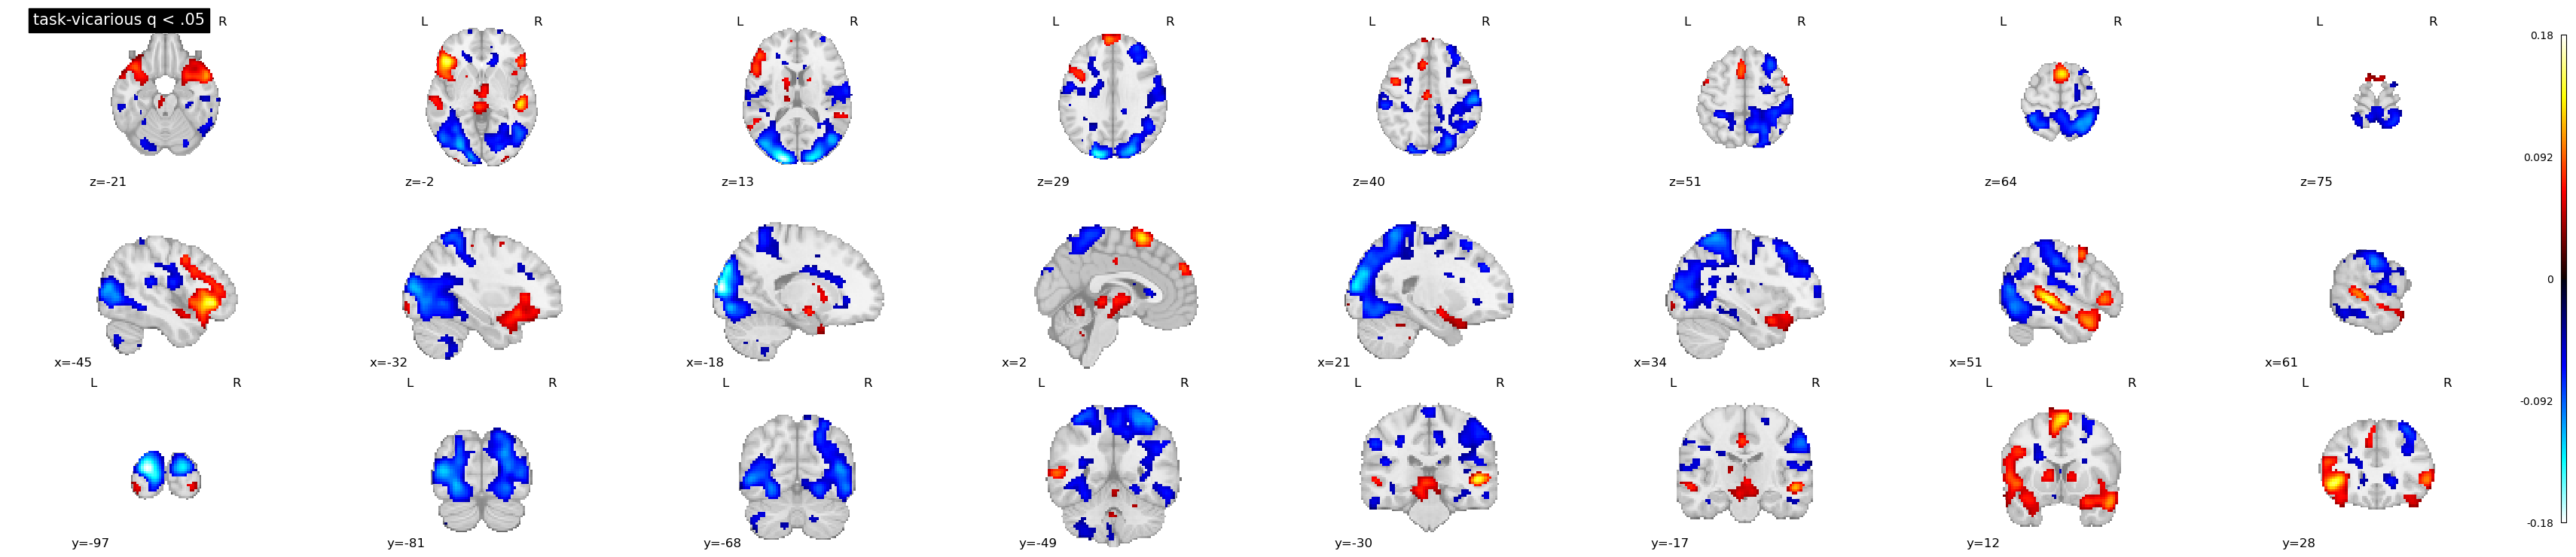

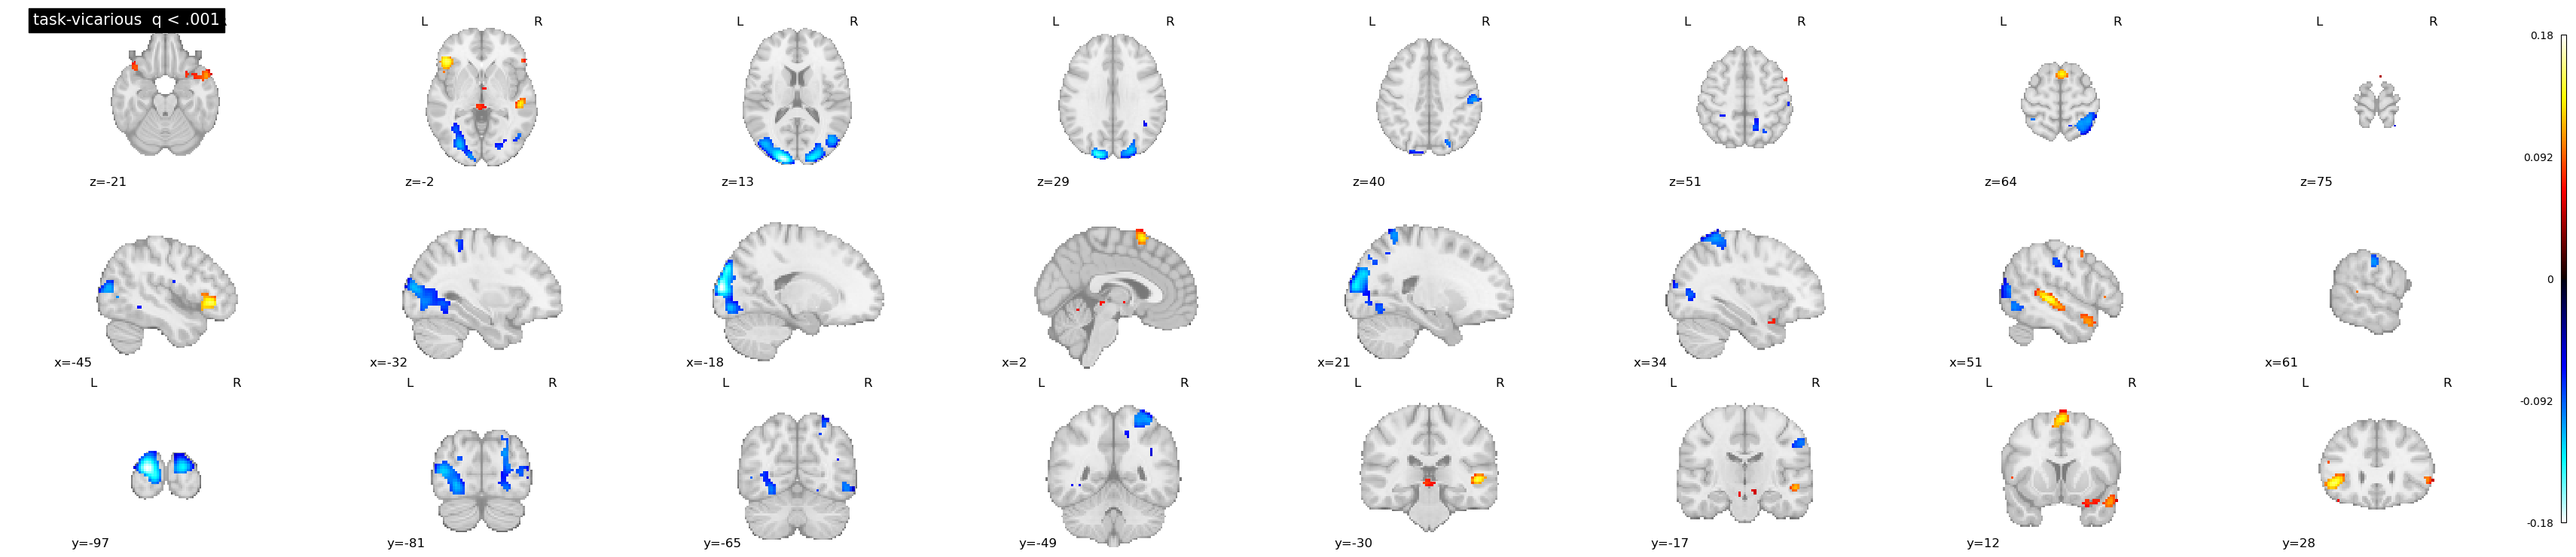

In [47]:
main_dir = '/Volumes/spacetop_projects_cue/'
task = 'vicarious'
fmri_event = 'stimulus'
beh_regressor = 'outcomerating'
nii_flist = glob.glob(join(main_dir, 'analysis', 'fmri', 'nilearn', 'covariate', beh_regressor, task, f"sub-*_task-{task}_corr_x-{fmri_event}_y-{beh_regressor}.nii.gz" ))

remove_sub = [1]
filtered_file_list = [file_path for file_path in nii_flist if not any(str(num) in file_path for num in remove_sub)]

# stack all files into a 4d nifti
concatenated_image = image.concat_imgs(sorted(filtered_file_list))
fmri_masked = nifti_masker.fit_transform(concatenated_image)

tvalues, pvalues = scipy.stats.ttest_1samp(fmri_masked, popmean=0,axis=0, alternative='two-sided', nan_policy = 'propagate')
reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')
tanhcorr_t = np.tanh(np.nanmean(fmri_masked, axis = 0))
                     
# map 1
con_t = nifti_masker.inverse_transform(tanhcorr_t)

# map 2
result_mapp = np.zeros(fmri_masked.shape[1])
result_mapp[qvalues < .05] = tanhcorr_t[qvalues < .05] #tvalues[qvalues < .05]
con_tmapp = nifti_masker.inverse_transform(result_mapp)

# map 3
result_map_001p = np.zeros(fmri_masked.shape[1])
result_map_001p[qvalues < .001] = tanhcorr_t[qvalues < .001] #tvalues[qvalues < .001]
con_tmap_001p = nifti_masker.inverse_transform(result_map_001p)

plotting.plot_stat_map(con_t,  display_mode = 'mosaic', title = f'task-{task} t values', cut_coords = 8)
plotting.plot_stat_map(con_tmapp,  display_mode = 'mosaic', title = f'task-{task} q < .05', cut_coords = 8)
plotting.plot_stat_map(con_tmap_001p,  display_mode = 'mosaic', title = f'task-{task}  q < .001', cut_coords = 8)

# cognitive

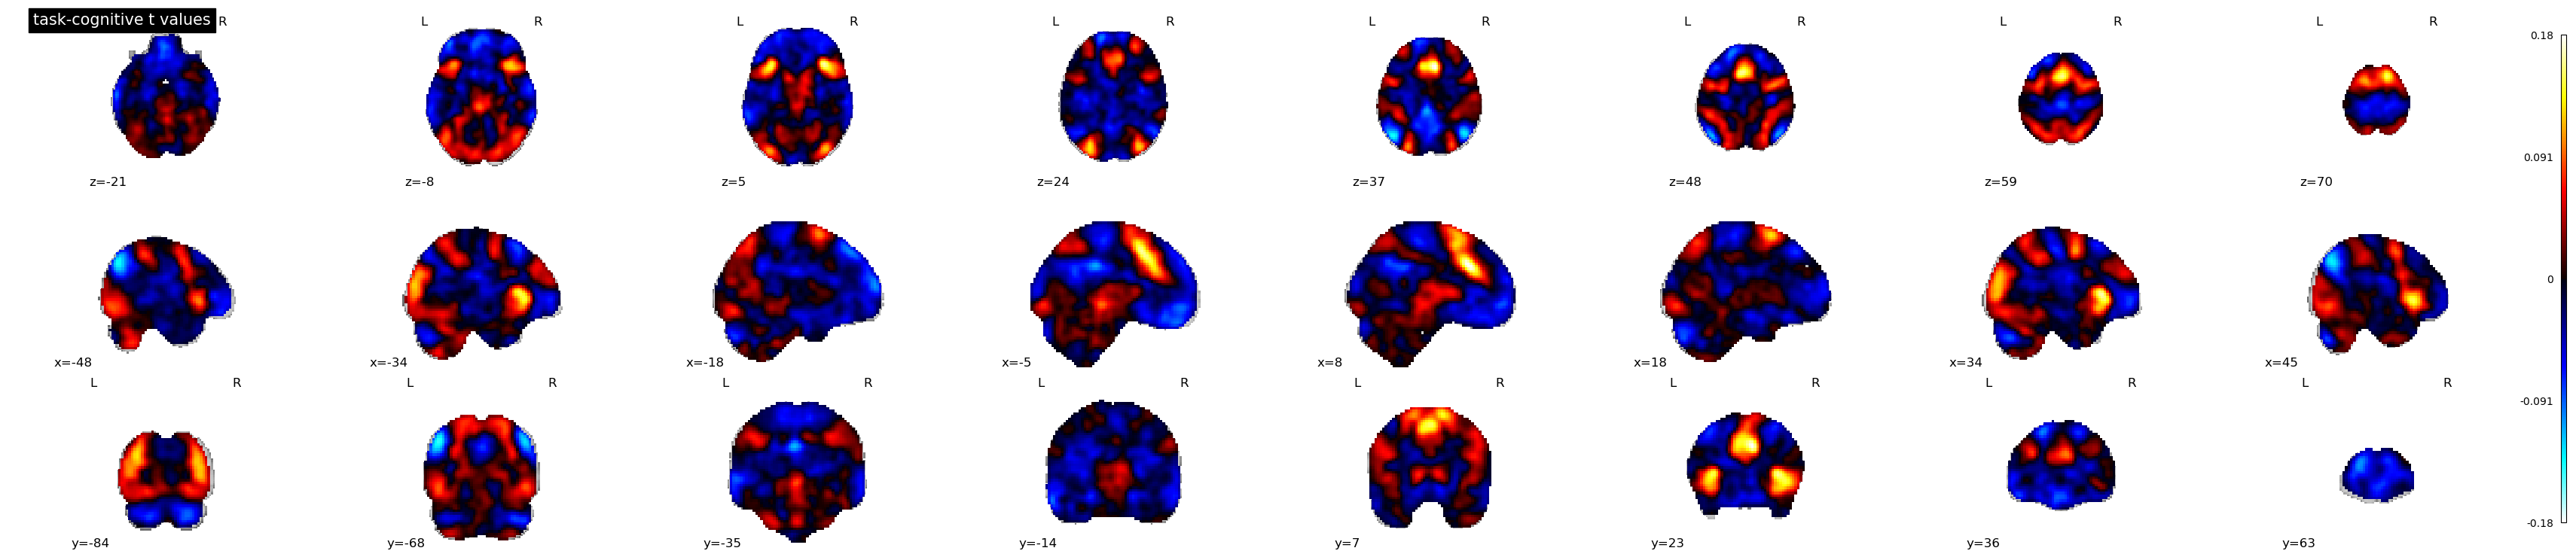

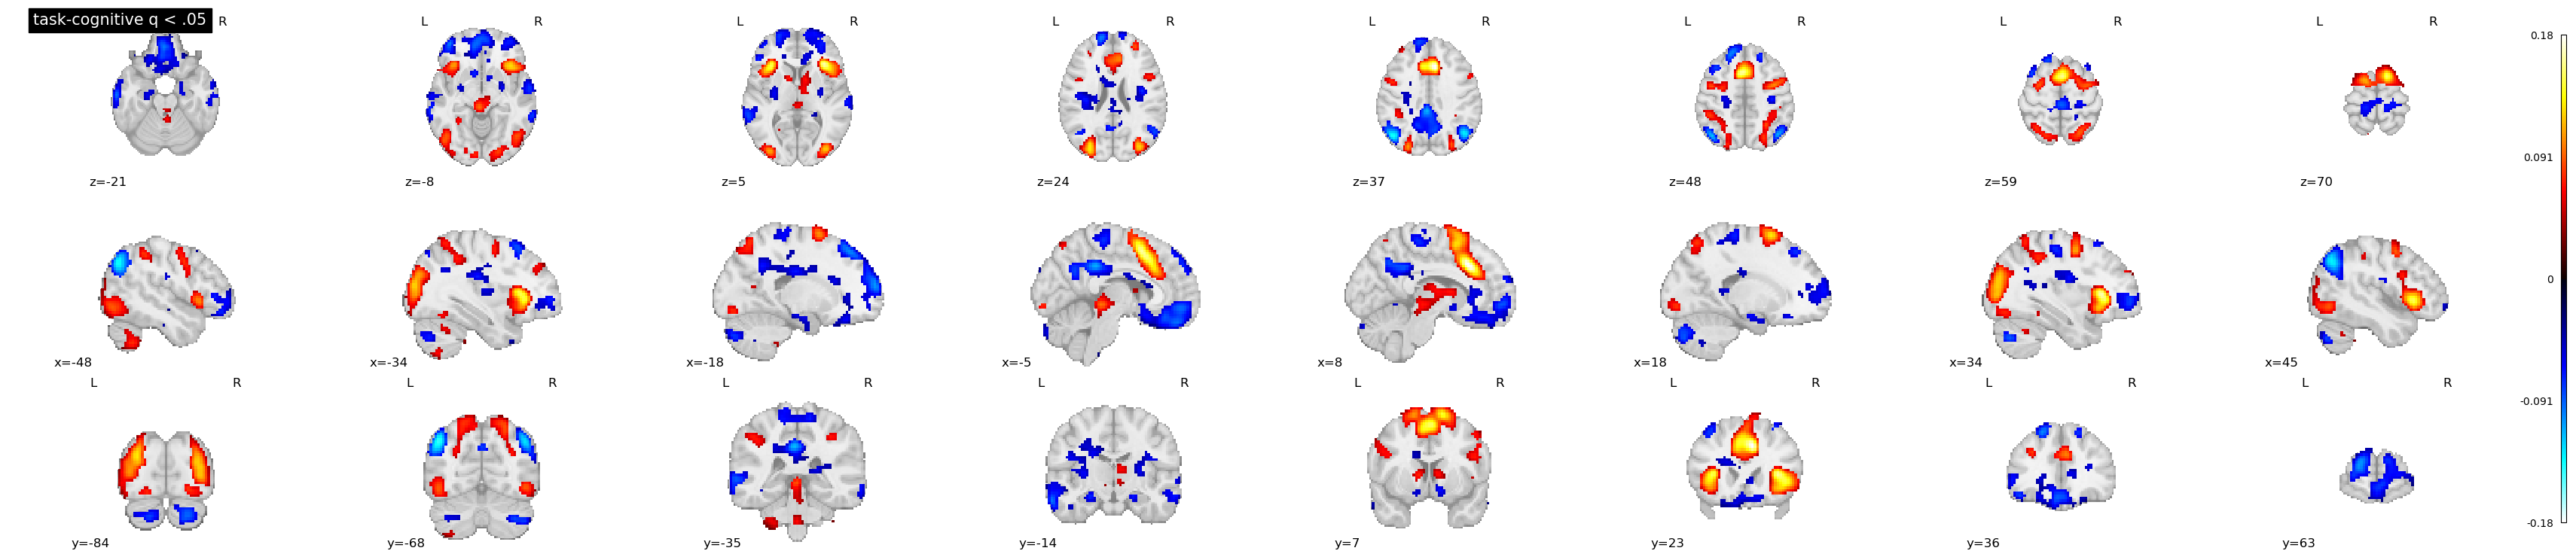

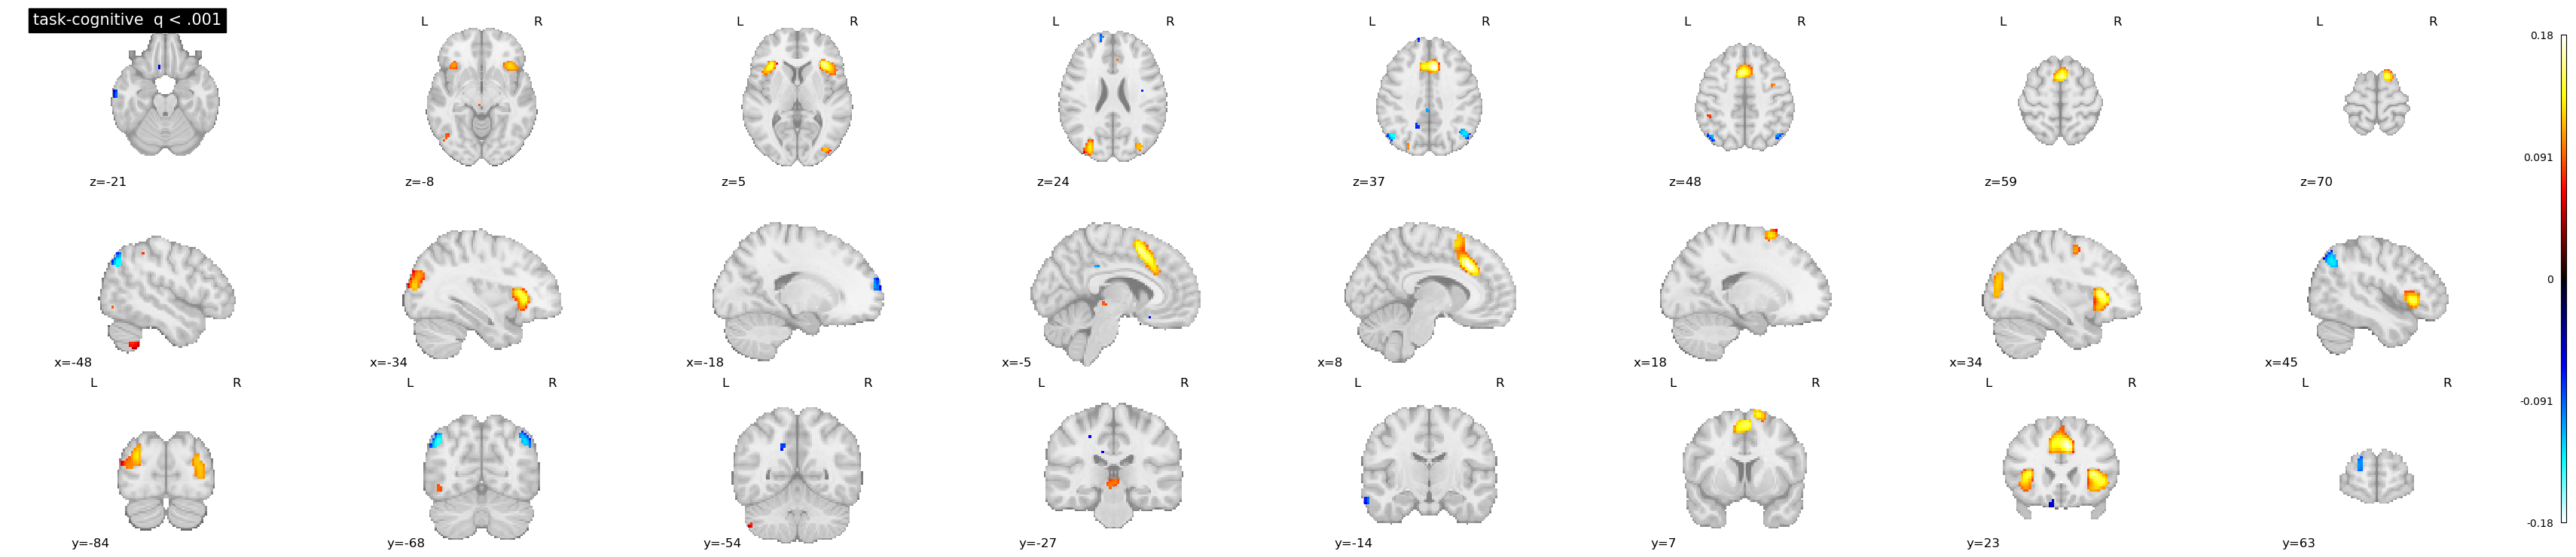

In [48]:
main_dir = '/Volumes/spacetop_projects_cue/'
task = 'cognitive'
fmri_event = 'stimulus'
beh_regressor = 'outcomerating'
nii_flist = glob.glob(join(main_dir, 'analysis', 'fmri', 'nilearn', 'covariate', beh_regressor, task, f"sub-*_task-{task}_corr_x-{fmri_event}_y-{beh_regressor}.nii.gz" ))

remove_sub = [1]
filtered_file_list = [file_path for file_path in nii_flist if not any(str(num) in file_path for num in remove_sub)]

# stack all files into a 4d nifti
concatenated_image = image.concat_imgs(sorted(filtered_file_list))
fmri_masked = nifti_masker.fit_transform(concatenated_image)

tvalues, pvalues = scipy.stats.ttest_1samp(fmri_masked, popmean=0,axis=0, alternative='two-sided', nan_policy = 'propagate')
reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')
tanhcorr_t = np.tanh(np.nanmean(fmri_masked, axis = 0))
                     
# map 1
cog_corr = nifti_masker.inverse_transform(tanhcorr_t)

# map 2
result_mapp = np.zeros(fmri_masked.shape[1])
result_mapp[qvalues < .05] = tanhcorr_t[qvalues < .05] #tvalues[qvalues < .05]
cog_corr_q05 = nifti_masker.inverse_transform(result_mapp)

# map 3
result_map_001p = np.zeros(fmri_masked.shape[1])
result_map_001p[qvalues < .001] = tanhcorr_t[qvalues < .001] #tvalues[qvalues < .001]
cog_corr_q001 = nifti_masker.inverse_transform(result_map_001p)

plotting.plot_stat_map(cog_corr,  display_mode = 'mosaic', title = f'task-{task} correlation', cut_coords = 8)
plotting.plot_stat_map(cog_corr_q05,  display_mode = 'mosaic', title = f'task-{task} q < .05', cut_coords = 8)
plotting.plot_stat_map(cog_corr_q001,  display_mode = 'mosaic', title = f'task-{task}  q < .001', cut_coords = 8)